# Generate Survival Dataset with HMM Features

In [1]:
import pandas as pd
import numpy as np
import yaml
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import os

with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_path"]

In [2]:
# ========================
# USER CONFIGURABLE BLOCK
# ========================
SKIP_FILTERING = True
DATASET = "mimic"
SAVE_RESULTS = False

In [3]:
with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [4]:
base_training_data_path = data_config['training_data'][DATASET]['preprocessed_path']
print(f"{base_training_data_path}")

/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure


## Load Data

In [5]:
subdir = '/multiple_hosp_patients' #"/relapse_cleaned"
training_data_path = base_training_data_path + subdir

In [ ]:
from recurrent_health_events_prediction.preprocessing.gen_dataset_hmm import load_data_for_inference_mimic, load_data_for_inference_relapse, process_mimic_events

if DATASET == "mimic":
   all_events_df, last_events_df, _, _ = load_data_for_inference_mimic(training_data_path)
   all_events_df, last_events_df = process_mimic_events(
            all_events_df,
            last_events_df,
            SKIP_FILTERING
        )
else:
    all_events_df, last_events_df, _, _ = load_data_for_inference_relapse(training_data_path)

Load all_events and last_events dataframes
All events CSV: /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/all_events.csv
Last events CSV: /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/last_events.csv


In [7]:
all_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 55 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            5397 non-null   int64         
 1   HADM_ID                               5397 non-null   int64         
 2   ADMITTIME                             5397 non-null   datetime64[ns]
 3   DISCHTIME                             5397 non-null   datetime64[ns]
 4   ADMISSION_TYPE                        5397 non-null   object        
 5   ETHNICITY                             5397 non-null   object        
 6   INSURANCE                             5397 non-null   object        
 7   HOSPITALIZATION_DAYS                  5397 non-null   float64       
 8   NUM_COMORBIDITIES                     5397 non-null   int64         
 9   TYPES_COMORBIDITIES                   5397 non-null   object        
 10  

In [8]:
last_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 55 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            1690 non-null   int64         
 1   HADM_ID                               1690 non-null   int64         
 2   ADMITTIME                             1690 non-null   datetime64[ns]
 3   DISCHTIME                             1690 non-null   datetime64[ns]
 4   ADMISSION_TYPE                        1690 non-null   object        
 5   ETHNICITY                             1690 non-null   object        
 6   INSURANCE                             1690 non-null   object        
 7   HOSPITALIZATION_DAYS                  1690 non-null   float64       
 8   NUM_COMORBIDITIES                     1690 non-null   int64         
 9   TYPES_COMORBIDITIES                   1690 non-null   object        
 10  

## Load HMM Model

In [9]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM
from recurrent_health_events_prediction.model.utils import load_model

model_name = "hmm_multiple_emissions_time_binary_4states"
base_model_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm"
save_dir = os.path.join(base_model_path, model_name)
model_pickle_path = os.path.join(save_dir, model_name + ".pkl")
hmm_feature_extractor_model: RecurrentHealthEventsHMM = load_model(model_pickle_path)
hmm_config = hmm_feature_extractor_model.config
print(f"Loaded model from {model_pickle_path}")

Loaded model from /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_multiple_emissions_time_binary_4states/hmm_multiple_emissions_time_binary_4states.pkl


In [10]:
print("HMM Model Config:")
for key, value in hmm_config.items():
    print(f"{key}: {value}")

HMM Model Config:
continuous_event_time_col: LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
event_id_col: HADM_ID
event_name: readmission
event_time_cat_col: READMISSION_TIME_CAT
event_time_feature_col: READMISSION_30_DAYS
feature_define_state_labels: READMISSION_30_DAYS
features: {'CHARLSON_INDEX': 'poisson', 'LOG_DAYS_IN_ICU': 'gaussian', 'READMISSION_30_DAYS': 'bernoulli'}
hidden_state_labels: ['low', 'medium_1', 'medium_2', 'high']
id_col: SUBJECT_ID
model_name: hmm_multiple_emissions_time_binary_4states
n_states: 4
save_model_path: /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm
time_col: ADMITTIME


In [11]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

model_name = hmm_config["model_name"]
feature_names = hmm_config.get("features", None)
if feature_names:
    feature_names = list(feature_names.keys())
event_name = hmm_config.get("event_name", "readmission")
event_time_feature_col = hmm_config.get("event_time_feature_col", None)
event_time_cat_col = hmm_config.get("event_time_cat_col", "READMISSION_TIME_CAT")
event_time_cat_order = hmm_config.get("event_time_cat_order", ["0-30", "30-120", "120+"])
event_id_col = hmm_config.get("event_id_col", "HADM_ID")
subject_id_col = hmm_config.get("id_col", "SUBJECT_ID")
time_col = hmm_config.get("time_col", "ADMITTIME")
hidden_states_labels_order = sort_state_labels_by_severity(hmm_config.get("hidden_state_labels", None))

In [12]:
labels = hmm_feature_extractor_model.get_hidden_state_labels()
print(f"Hidden states labels: {labels}")
print("Hidden states labels order: ", hidden_states_labels_order)

Hidden states labels: {0: 'low', 1: 'medium_1', 3: 'medium_2', 2: 'high'}
Hidden states labels order:  ['high', 'medium_2', 'medium_1', 'low']


## Inference of Last Hidden States - Partial Observations

In [13]:
all_events_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,AFTER_HOSP_DEATH_EVENT,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT
0,107,191941,2115-02-20 17:41:00,2115-02-21 16:30:00,EMERGENCY,HISPANIC OR LATINO,Private,0.950694,2,"['renal_disease', 'other']",...,0,0.668185,0.702404,7.814044,NaN,0.000000,NaN,NaN,0,1
1,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,EMERGENCY,HISPANIC OR LATINO,Medicare,4.787500,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,1.755700,0.732641,5.082779,7.814044,0.693147,7.814044,7.814044,1,0
2,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Government,16.942361,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,2.887164,2.411849,4.990296,NaN,0.000000,NaN,NaN,0,1
3,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.927778,4,"['renal_disease', 'cerebrovascular_disease', '...",...,0,1.368074,1.388872,6.462862,4.990296,0.693147,4.990296,4.990296,0,1
4,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.000000,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,1.098612,1.097300,2.528392,6.462862,1.098612,5.976189,5.976189,0,1


In [14]:
last_events_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,AFTER_HOSP_DEATH_EVENT,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT
0,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,EMERGENCY,HISPANIC OR LATINO,Medicare,4.787500,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,1.755700,0.732641,5.082779,7.814044,0.693147,7.814044,7.814044,1,0
1,109,155726,2142-08-13 04:03:00,2142-08-16 18:17:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,3.593056,6,"['peripheral_vascular_disease', 'peptic_ulcer_...",...,0,1.524546,1.009414,2.569799,3.062937,3.496508,3.894755,2.698958,1,0
2,236,182562,2135-05-26 11:28:00,2135-05-28 16:46:00,EMERGENCY,PATIENT DECLINED TO ANSWER,Private,2.220833,2,"['mild_liver_disease', 'other']",...,0,1.169640,0.848175,7.217372,5.410802,0.693147,5.410802,5.410802,1,0
3,249,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,EMERGENCY,WHITE,Medicare,10.624306,8,"['chronic_pulmonary_disease', 'cerebrovascular...",...,0,2.453098,1.918345,6.084907,7.528989,0.693147,7.528989,7.528989,1,0
4,256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,Medicare,12.549306,4,"['chronic_pulmonary_disease', 'peripheral_vasc...",...,0,2.606335,2.153851,3.929890,7.257424,1.098612,7.132493,7.132493,1,0


In [ ]:
from recurrent_health_events_prediction.preprocessing.gen_dataset_hmm import (
    extract_partial_trajectories,
)

(
    last_observed_event_ids,
    last_censored_event_ids,
    events_up_to_last_obs_df,
    events_up_to_last_censored_df,
) = extract_partial_trajectories(
    all_events_df,
    last_events_df,
    event_time_feature_col,
    event_name=event_name,
    event_id_col=event_id_col,
    subject_id_col=subject_id_col,
    time_col=time_col,
)

In [16]:
print("Number of last observed events:", len(last_observed_event_ids))
print("Number of last censored events:", len(last_censored_event_ids))

Number of last observed events: 801
Number of last censored events: 889


In [17]:
if event_time_feature_col is not None:
    assert events_up_to_last_censored_df.loc[events_up_to_last_censored_df[event_id_col].isin(last_censored_event_ids), event_time_feature_col].notna().sum() == 0, "There are still non-NaN values in the time feature column for last events in the censored data."
    assert events_up_to_last_obs_df.loc[events_up_to_last_obs_df[event_id_col].isin(last_observed_event_ids), event_time_feature_col].notna().sum() == 0, "There are still non-NaN values in the time feature column for last events in the observed data."

In [18]:
events_up_to_last_obs_df[[subject_id_col, event_id_col, time_col, event_time_cat_col, event_time_feature_col]].head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,READMISSION_TIME_CAT,READMISSION_30_DAYS
2,109,183350,2137-11-04 19:36:00,120+,0.0
3,109,128755,2138-04-16 17:44:00,120+,0.0
4,109,164029,2140-01-19 13:25:00,0-30,1.0
5,109,108375,2140-02-02 02:13:00,30-120,0.0
6,109,193281,2140-04-07 19:51:00,0-30,1.0
7,109,175347,2140-05-17 14:27:00,30-120,0.0
8,109,110668,2140-08-25 14:39:00,120+,0.0
9,109,166018,2141-03-27 21:08:00,30-120,0.0
10,109,170149,2141-05-24 14:47:00,0-30,1.0
11,109,147469,2141-06-11 10:17:00,30-120,0.0


In [19]:
events_up_to_last_censored_df[[subject_id_col, event_id_col, time_col, event_time_cat_col, event_time_feature_col]].head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,READMISSION_TIME_CAT,READMISSION_30_DAYS
0,107,191941,2115-02-20 17:41:00,120+,0.0
1,107,182383,2121-11-30 19:24:00,120+,NaN
35,236,151459,2134-10-04 01:19:00,120+,0.0
36,236,182562,2135-05-26 11:28:00,120+,NaN
37,249,116935,2149-12-17 20:41:00,120+,0.0
38,249,149546,2155-02-03 20:16:00,120+,NaN
42,291,113649,2102-04-08 22:26:00,120+,0.0
43,291,125726,2106-04-17 12:24:00,120+,NaN
44,305,133059,2125-04-26 11:45:00,120+,0.0
45,305,108015,2125-12-31 18:40:00,120+,0.0


### Inference of Last Hidden State - Partial Observations

In [ ]:
# Compute probabilities and map states
from recurrent_health_events_prediction.preprocessing.gen_dataset_hmm_utils import build_hidden_state_results, compute_hidden_state_probs

probs_obs = compute_hidden_state_probs(hmm_feature_extractor_model, events_up_to_last_obs_df)
probs_cens = compute_hidden_state_probs(hmm_feature_extractor_model, events_up_to_last_censored_df)

labels = hmm_feature_extractor_model.get_hidden_state_labels()
labels_to_idx = {label: index for index, label in labels.items()}
results_obs = build_hidden_state_results(last_observed_event_ids.values, probs_obs, labels, labels_to_idx, event_id_col=event_id_col)
results_cens = build_hidden_state_results(last_censored_event_ids.values, probs_cens, labels, labels_to_idx, event_id_col=event_id_col)
last_hidden_states_df = pd.concat([results_obs, results_cens], ignore_index=True)

In [21]:
last_hidden_states_df.head(10)

,HADM_ID,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_LOW,PROB_HIDDEN_RISK_MEDIUM_1,PROB_HIDDEN_RISK_MEDIUM_2,PROB_HIDDEN_RISK_HIGH
0,155726,low,0.507260,0.117214,0.230693,0.144833
1,188869,medium_2,0.208133,0.118531,0.399747,0.273589
2,128132,high,0.039003,0.191190,0.353763,0.416044
3,101651,low,0.546692,0.087407,0.226750,0.139151
4,185375,low,0.359278,0.232283,0.221023,0.187415
5,152089,low,0.482323,0.125375,0.230641,0.161660
6,160425,low,0.653679,0.048494,0.202373,0.095454
7,189928,medium_2,0.307721,0.121433,0.348575,0.222271
8,197130,low,0.586110,0.052893,0.248059,0.112937
9,162589,medium_1,0.148340,0.446133,0.189247,0.216280


In [22]:
last_hidden_states_df.columns

Index(['HADM_ID', 'HEALTH_HIDDEN_RISK', 'PROB_HIDDEN_RISK_LOW',
       'PROB_HIDDEN_RISK_MEDIUM_1', 'PROB_HIDDEN_RISK_MEDIUM_2',
       'PROB_HIDDEN_RISK_HIGH'],
      dtype='object')

In [23]:
last_events_with_hmm_features_df = last_events_df.merge(last_hidden_states_df, on=event_id_col, how="left")

In [24]:
last_events_with_hmm_features_df.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_LOW,PROB_HIDDEN_RISK_MEDIUM_1,PROB_HIDDEN_RISK_MEDIUM_2,PROB_HIDDEN_RISK_HIGH
0,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,EMERGENCY,HISPANIC OR LATINO,Medicare,4.787500,4,"['renal_disease', 'congestive_heart_failure', ...",...,0.693147,7.814044,7.814044,1,0,low,0.496104,0.122704,0.227502,0.153690
1,109,155726,2142-08-13 04:03:00,2142-08-16 18:17:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,3.593056,6,"['peripheral_vascular_disease', 'peptic_ulcer_...",...,3.496508,3.894755,2.698958,1,0,low,0.507260,0.117214,0.230693,0.144833
2,236,182562,2135-05-26 11:28:00,2135-05-28 16:46:00,EMERGENCY,PATIENT DECLINED TO ANSWER,Private,2.220833,2,"['mild_liver_disease', 'other']",...,0.693147,5.410802,5.410802,1,0,medium_1,0.202775,0.409333,0.181312,0.206581
3,249,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,EMERGENCY,WHITE,Medicare,10.624306,8,"['chronic_pulmonary_disease', 'cerebrovascular...",...,0.693147,7.528989,7.528989,1,0,low,0.606831,0.014923,0.289219,0.089027
4,256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,Medicare,12.549306,4,"['chronic_pulmonary_disease', 'peripheral_vasc...",...,1.098612,7.132493,7.132493,1,0,medium_2,0.208133,0.118531,0.399747,0.273589
5,291,125726,2106-04-17 12:24:00,2106-04-19 15:10:00,EMERGENCY,WHITE,Medicare,2.115278,4,"['peptic_ulcer_disease', 'other', 'rheumatic_d...",...,0.693147,7.290958,7.290958,1,0,low,0.499606,0.123384,0.227776,0.149233
6,305,122211,2127-06-19 23:49:00,2127-07-16 13:58:00,EMERGENCY,WHITE,Medicare,26.589583,3,"['congestive_heart_failure', 'diabetes_with_cc...",...,1.098612,5.952636,5.952636,1,0,medium_2,0.217336,0.155016,0.362168,0.265480
7,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,Medicare,14.927778,4,"['congestive_heart_failure', 'diabetes_with_cc...",...,1.098612,6.667396,6.667396,1,0,high,0.039003,0.191190,0.353763,0.416044
8,339,107660,2188-04-01 07:11:00,2188-04-18 15:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,17.343056,1,['other'],...,1.098612,4.946568,4.946568,1,0,medium_1,0.097273,0.423426,0.218421,0.260879
9,353,131488,2151-10-01 20:42:00,2151-10-20 15:20:00,EMERGENCY,WHITE,Medicare,18.776389,4,"['renal_disease', 'congestive_heart_failure', ...",...,1.386294,5.957983,4.503199,1,0,low,0.520725,0.110854,0.228489,0.139932


In [25]:
print(f"Number of events in last events: {len(last_events_with_hmm_features_df)}")
print("Number of patients in last events:", last_events_with_hmm_features_df[subject_id_col].nunique())

Number of events in last events: 1690
Number of patients in last events: 1690


## Inference of Past Hidden States - Full Observations

In [26]:
from recurrent_health_events_prediction.preprocessing.utils import get_past_events

past_events_obs_df = get_past_events(events_up_to_last_obs_df, subject_id_col)
past_events_cens_df = get_past_events(events_up_to_last_censored_df, subject_id_col)

In [27]:
past_events_obs_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,AFTER_HOSP_DEATH_EVENT,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT
2,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Government,16.942361,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,2.887164,2.411849,4.990296,NaN,0.000000,NaN,NaN,0,1
3,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.927778,4,"['renal_disease', 'cerebrovascular_disease', '...",...,0,1.368074,1.388872,6.462862,4.990296,0.693147,4.990296,4.990296,0,1
4,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.000000,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,1.098612,1.097300,2.528392,6.462862,1.098612,5.976189,5.976189,0,1
5,109,108375,2140-02-02 02:13:00,2140-02-02 16:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,0.591667,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,0.464782,0.463508,4.191820,2.528392,1.386294,5.586506,4.990296,0,1
6,109,193281,2140-04-07 19:51:00,2140-05-02 16:30:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,24.860417,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,3.252713,2.089299,2.767236,4.191820,1.609438,5.378224,4.668722,0,1


In [28]:
from recurrent_health_events_prediction.training.utils_hmm import summarize_hidden_state_counts_from_df

past_hidden_states_obs_count_df = summarize_hidden_state_counts_from_df(past_events_obs_df, hmm_feature_extractor_model, subject_id_col=subject_id_col)
past_hidden_states_obs_count_df.head()

HEALTH_HIDDEN_RISK,SUBJECT_ID,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM_1,PAST_COUNT_HIDDEN_RISK_MEDIUM_2
0,109,3,11,15,3
1,256,0,2,0,0
2,323,0,2,0,0
3,357,2,0,0,1
4,518,0,7,0,0


In [29]:
past_hidden_states_censored_count_df = summarize_hidden_state_counts_from_df(past_events_cens_df, hmm_feature_extractor_model, subject_id_col=subject_id_col)
past_hidden_states_censored_count_df.head()

HEALTH_HIDDEN_RISK,SUBJECT_ID,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM_1,PAST_COUNT_HIDDEN_RISK_MEDIUM_2
0,107,0,1,0,0
1,236,0,1,0,0
2,249,0,1,0,0
3,291,0,1,0,0
4,305,0,2,0,0


In [30]:
past_hidden_states_count_df = pd.concat([past_hidden_states_obs_count_df, past_hidden_states_censored_count_df], ignore_index=True)

In [31]:
last_events_with_hmm_features_df = last_events_with_hmm_features_df.merge(
    past_hidden_states_count_df, on=subject_id_col, how="left"
)
past_count_cols = [col for col in last_events_with_hmm_features_df.columns if col.startswith("PAST_COUNT")]
last_events_with_hmm_features_df[past_count_cols] = last_events_with_hmm_features_df[past_count_cols].fillna(0.0).astype(int)
last_events_with_hmm_features_df.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,IS_HISTORICAL_EVENT,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_LOW,PROB_HIDDEN_RISK_MEDIUM_1,PROB_HIDDEN_RISK_MEDIUM_2,PROB_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM_1,PAST_COUNT_HIDDEN_RISK_MEDIUM_2
0,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,EMERGENCY,HISPANIC OR LATINO,Medicare,4.787500,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,low,0.496104,0.122704,0.227502,0.153690,0,1,0,0
1,109,155726,2142-08-13 04:03:00,2142-08-16 18:17:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,3.593056,6,"['peripheral_vascular_disease', 'peptic_ulcer_...",...,0,low,0.507260,0.117214,0.230693,0.144833,3,11,15,3
2,236,182562,2135-05-26 11:28:00,2135-05-28 16:46:00,EMERGENCY,PATIENT DECLINED TO ANSWER,Private,2.220833,2,"['mild_liver_disease', 'other']",...,0,medium_1,0.202775,0.409333,0.181312,0.206581,0,1,0,0
3,249,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,EMERGENCY,WHITE,Medicare,10.624306,8,"['chronic_pulmonary_disease', 'cerebrovascular...",...,0,low,0.606831,0.014923,0.289219,0.089027,0,1,0,0
4,256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,Medicare,12.549306,4,"['chronic_pulmonary_disease', 'peripheral_vasc...",...,0,medium_2,0.208133,0.118531,0.399747,0.273589,0,2,0,0
5,291,125726,2106-04-17 12:24:00,2106-04-19 15:10:00,EMERGENCY,WHITE,Medicare,2.115278,4,"['peptic_ulcer_disease', 'other', 'rheumatic_d...",...,0,low,0.499606,0.123384,0.227776,0.149233,0,1,0,0
6,305,122211,2127-06-19 23:49:00,2127-07-16 13:58:00,EMERGENCY,WHITE,Medicare,26.589583,3,"['congestive_heart_failure', 'diabetes_with_cc...",...,0,medium_2,0.217336,0.155016,0.362168,0.265480,0,2,0,0
7,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,Medicare,14.927778,4,"['congestive_heart_failure', 'diabetes_with_cc...",...,0,high,0.039003,0.191190,0.353763,0.416044,0,2,0,0
8,339,107660,2188-04-01 07:11:00,2188-04-18 15:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,17.343056,1,['other'],...,0,medium_1,0.097273,0.423426,0.218421,0.260879,1,1,0,0
9,353,131488,2151-10-01 20:42:00,2151-10-20 15:20:00,EMERGENCY,WHITE,Medicare,18.776389,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,low,0.520725,0.110854,0.228489,0.139932,0,3,0,0


## Plots

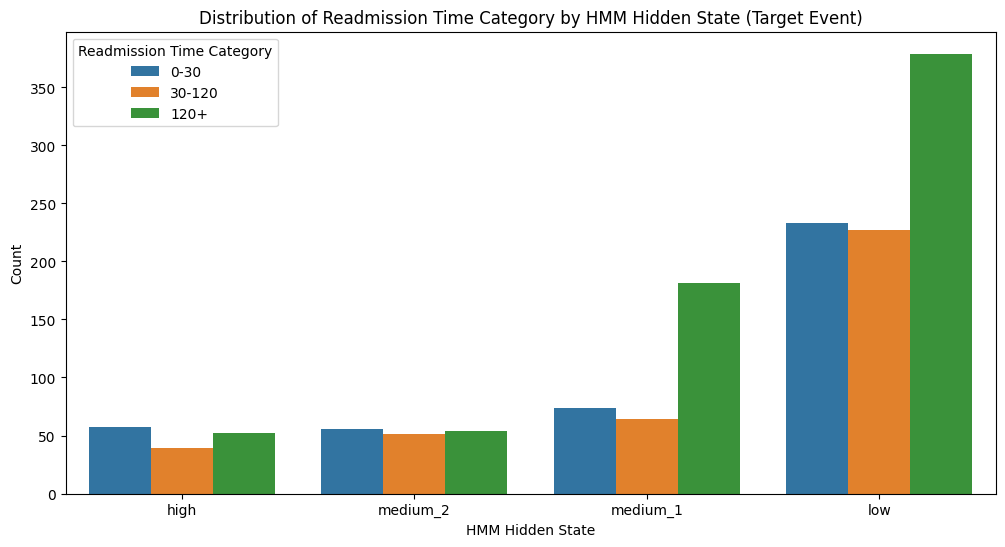

In [32]:
from recurrent_health_events_prediction.training.utils_hmm import plot_cat_event_time_by_hidden_state

filename = f"target_{event_name}_time_cat_by_hidden_state.png"
# filepath = os.path.join(save_dir, filename)
#print(f"Saving plot to {filepath}")
fig = plot_cat_event_time_by_hidden_state(
    last_events_with_hmm_features_df,
    time_cat_col = event_time_cat_col,
    title_suffix=' (Target Event)',
    event_name=event_name,
    hue_order=event_time_cat_order,
    save_file=None,
    hidden_states_order=hidden_states_labels_order,
    show_plot=True
)

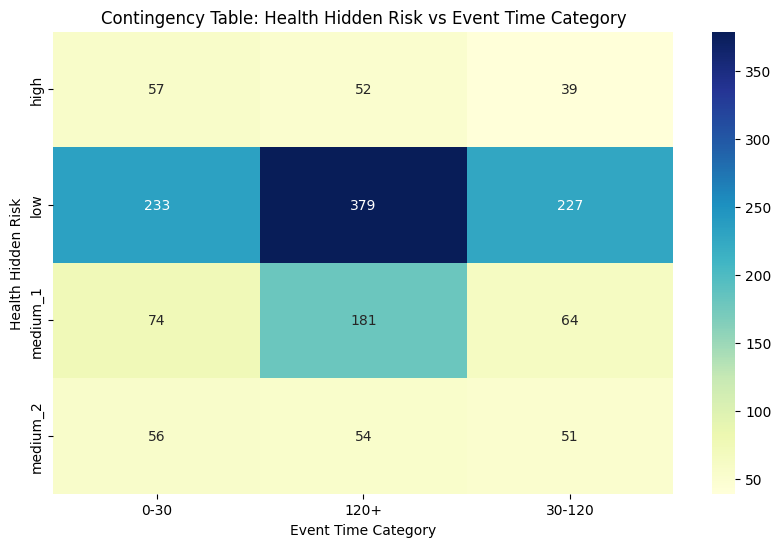

In [ ]:
from recurrent_health_events_prediction.preprocessing.gen_dataset_hmm_utils import run_chi2_and_plot

results_str, fig = run_chi2_and_plot(last_events_with_hmm_features_df, event_time_cat_col=event_time_cat_col, show_plot=True)

In [34]:
print(results_str)

Chi-squared statistic: 34.8456091501737
P-value: 4.616696477507928e-06
Degrees of freedom: 6



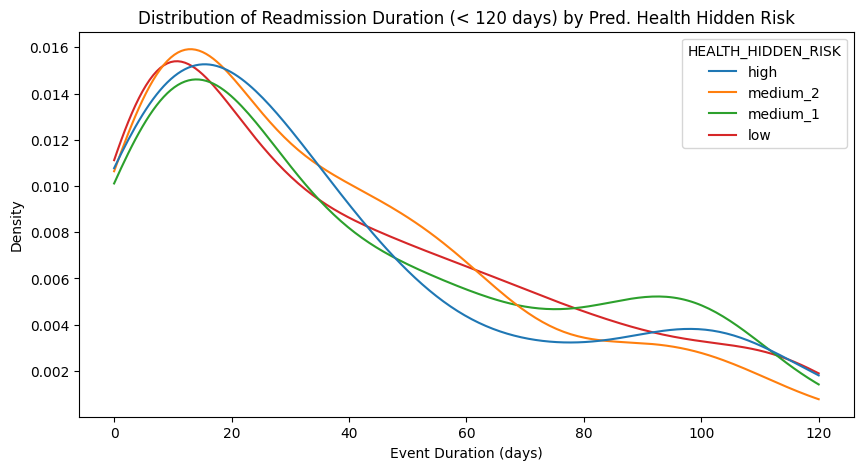

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns

# Only readmitted events
event_col = f"{event_name.upper()}_EVENT"
last_observed_events_hmm_features_df = last_events_with_hmm_features_df[last_events_with_hmm_features_df[event_col] == 1]

fig, ax = plt.subplots(figsize=(10, 5))
    # use label names instead of idx in hue_order if possible
upper_limit = np.ceil(last_observed_events_hmm_features_df['EVENT_DURATION'].max()).item()
sns.kdeplot(
    last_observed_events_hmm_features_df,
    x='EVENT_DURATION',
    hue='HEALTH_HIDDEN_RISK',
    common_norm=False,
    hue_order=hidden_states_labels_order,
    clip=(0, upper_limit),
    ax=ax
)
plt.title(f'Distribution of {event_name.title()} Duration (< {int(upper_limit)} days) by Pred. Health Hidden Risk')
plt.xlabel('Event Duration (days)')
plt.ylabel('Density')
plt.show()
plt.close()

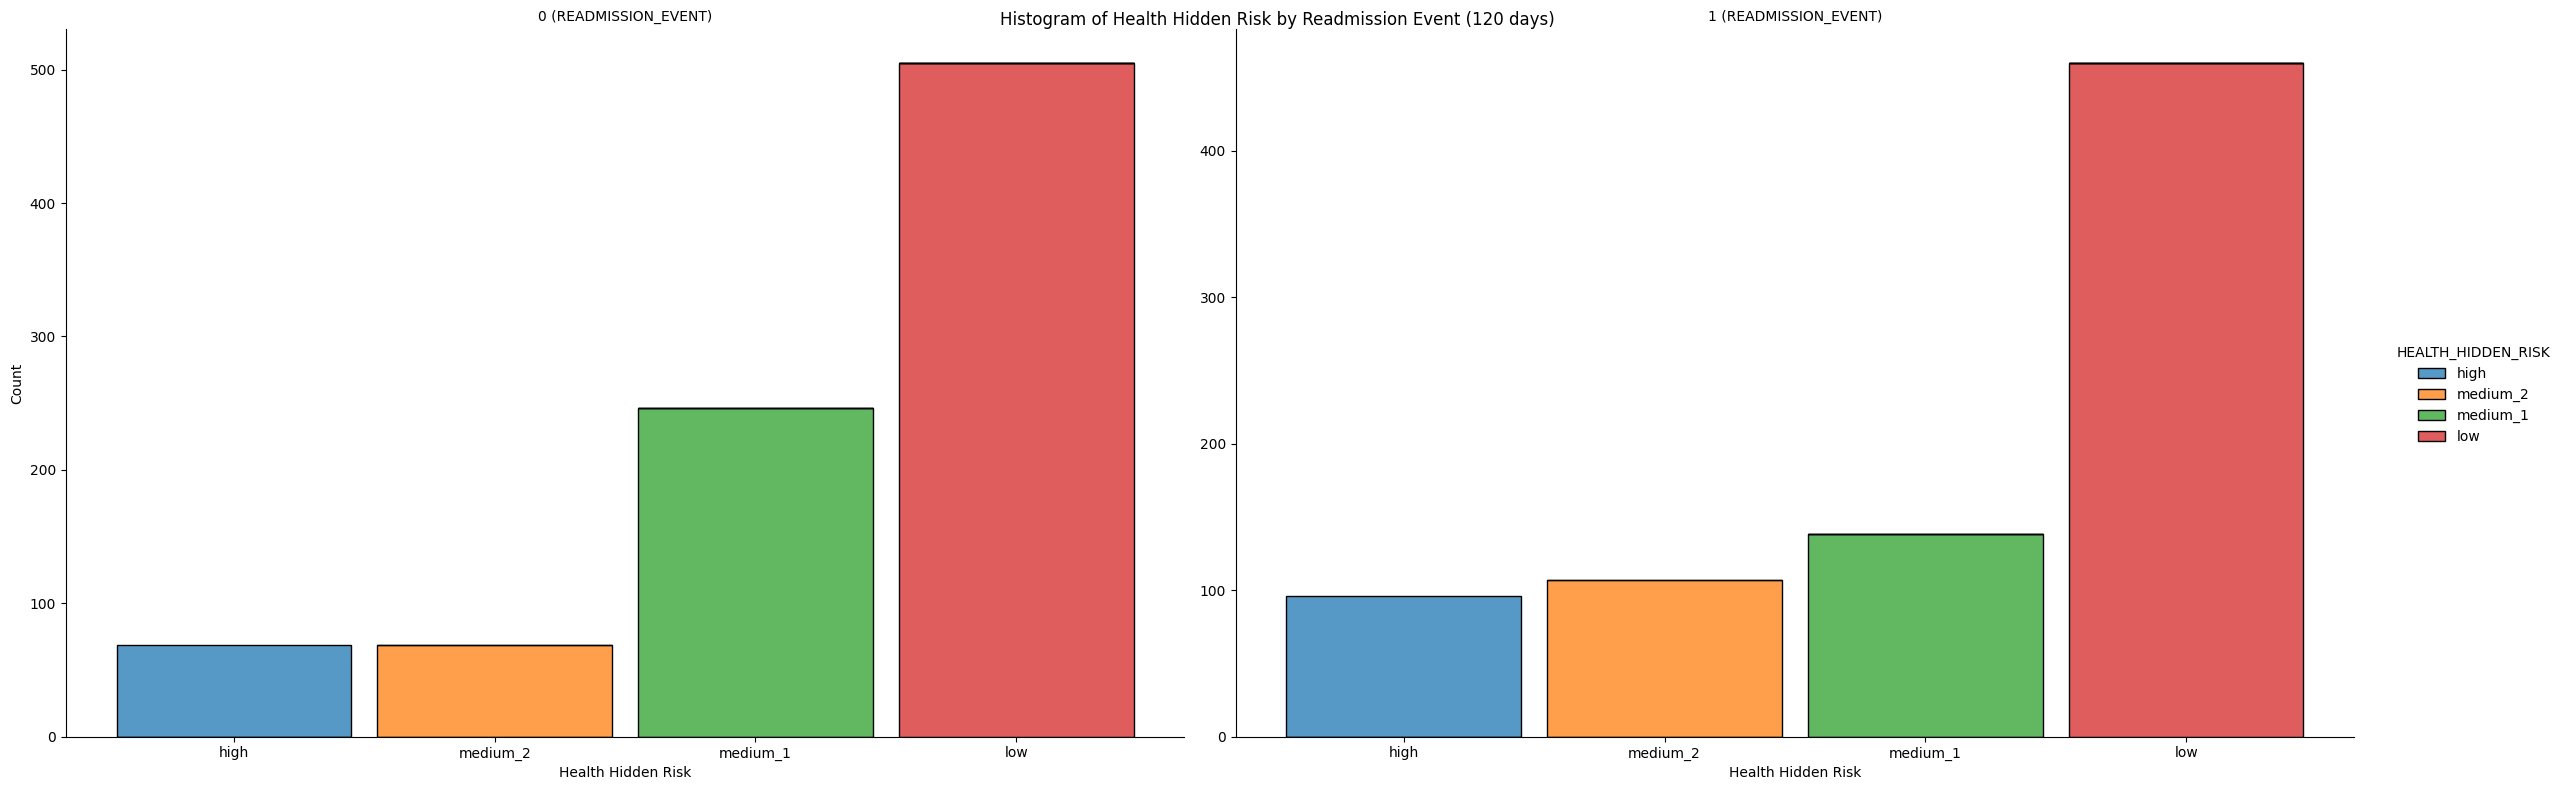

Facet histogram plot saved to None


In [ ]:
from recurrent_health_events_prediction.preprocessing.gen_dataset_hmm_utils import plot_facet_hidden_state_distribution

fig = plot_facet_hidden_state_distribution(
    last_events_with_hmm_features_df,
    hue_order=hidden_states_labels_order,
    axis_order=hidden_states_labels_order,
    event_name=event_name,
    show_plot=True,
    title=f"Histogram of Health Hidden Risk by {event_name.title()} Event ({int(upper_limit)} days)",
)

## Trajectory Inspection

In [37]:
events_up_to_last_obs_df

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,AFTER_HOSP_DEATH_EVENT,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT
2,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Government,16.942361,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,2.887164,2.411849,4.990296,NaN,0.000000,NaN,NaN,0,1
3,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.927778,4,"['renal_disease', 'cerebrovascular_disease', '...",...,0,1.368074,1.388872,6.462862,4.990296,0.693147,4.990296,4.990296,0,1
4,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.000000,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,1.098612,1.097300,2.528392,6.462862,1.098612,5.976189,5.976189,0,1
5,109,108375,2140-02-02 02:13:00,2140-02-02 16:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,0.591667,3,"['renal_disease', 'other', 'rheumatic_disease']",...,0,0.464782,0.463508,4.191820,2.528392,1.386294,5.586506,4.990296,0,1
6,109,193281,2140-04-07 19:51:00,2140-05-02 16:30:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,24.860417,4,"['renal_disease', 'congestive_heart_failure', ...",...,0,3.252713,2.089299,2.767236,4.191820,1.609438,5.378224,4.668722,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5383,99439,145935,2179-03-18 11:27:00,2179-03-20 18:00:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicare,2.272917,7,"['dementia', 'chronic_pulmonary_disease', 'cer...",...,0,1.185682,0.791918,2.093663,3.082706,0.693147,3.082706,3.082706,0,1
5384,99439,177794,2179-03-27 20:45:00,2179-04-01 15:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicare,4.788194,5,"['chronic_pulmonary_disease', 'cerebrovascular...",...,0,1.755820,1.413198,5.204155,2.093663,1.098612,2.705779,2.705779,0,1
5385,99439,152370,2179-09-29 16:19:00,2179-10-04 16:45:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicare,5.018056,6,"['chronic_pulmonary_disease', 'cerebrovascular...",...,0,1.794764,0.678791,3.972452,5.204155,1.386294,4.257781,3.082706,1,0
5395,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,EMERGENCY,WHITE,Medicare,10.075694,2,"['congestive_heart_failure', 'other']",...,0,2.404753,2.191571,3.372598,NaN,0.000000,NaN,NaN,0,1


In [38]:
from recurrent_health_events_prediction.visualization.utils import (
    plot_subject_evolution, plot_positive_dates_timeline_of_a_donor, plot_donor_relapse_evolution
)

if DATASET == "mimic":
    subject_id = 357
    features_to_plot = [
        "CHARLSON_INDEX",
        "LOG_HOSPITALIZATION_DAYS",
        "LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION",
        "READMISSION_TIME_CAT",
    ]
    save_html_file_path = os.path.join(
        save_dir, f"subject_{subject_id}_evolution_until_last_hosp.html"
    )  if SAVE_RESULTS else None
    events_plot_df = events_up_to_last_obs_df[
        events_up_to_last_obs_df["SUBJECT_ID"] == subject_id
    ].copy()
    plot_subject_evolution(
        events_plot_df,
        subject_id,
        features_to_plot=features_to_plot,
        textposition="auto",
        extend_time_horizon_by=45,
        save_html_file_path=save_html_file_path,
    )

elif DATASET == "relapse":
    all_drug_tests_df = pd.read_csv(base_training_data_path + "/all_drug_tests.csv")
    subject_id = 10141
    events_plot_df = events_up_to_last_obs_df[
        events_up_to_last_obs_df["DONOR_ID"] == subject_id
    ].copy()
    plot_positive_dates_timeline_of_a_donor(
        subject_id,
        all_drug_tests_df,
        time_col="TIME",
        donor_id_col="DONOR_ID",
        result_col="DRUG_POSITIVE",
    )
    events_up_to_last_obs_df['RELAPSE_END'] = pd.to_datetime(events_up_to_last_obs_df["RELAPSE_END"])
    plot_donor_relapse_evolution(events_up_to_last_obs_df, donor_id=subject_id, textposition='inside')

In [39]:
subject_readmission_ids = past_events_obs_df[subject_id_col].drop_duplicates().tolist()
subject_censored_ids = past_events_cens_df[subject_id_col].drop_duplicates().tolist()

probs_past_events_readmission = hmm_feature_extractor_model.predict_proba(past_events_obs_df)

In [40]:
from recurrent_health_events_prediction.visualization.utils import plot_hidden_risk_states_patient

idx_subject = subject_readmission_ids.index(subject_id)
past_probs = probs_past_events_readmission[idx_subject]

In [41]:
prob_cols = [col for col in last_events_with_hmm_features_df.columns if col.startswith("PROB_")]
last_partial_probs = last_events_with_hmm_features_df.loc[last_events_with_hmm_features_df[subject_id_col] == subject_id, prob_cols].values.tolist()


In [42]:
last_partial_probs

[[0.5466922521591187,
  0.08740656077861786,
  0.22674956917762756,
  0.13915123045444489]]

In [43]:
hidden_states_labels_order

['high', 'medium_2', 'medium_1', 'low']

In [44]:
from recurrent_health_events_prediction.visualization.utils import generate_color_mapping_with_plotly

all_probs = past_probs + last_partial_probs

hidden_states_mapping = hmm_feature_extractor_model.get_hidden_state_labels()
color_mapping = generate_color_mapping_with_plotly(hidden_states_labels_order, color_scale_name="Viridis", descending=True)

plot_hidden_risk_states_patient(all_probs, hidden_states_mapping, colors=color_mapping)

In [45]:
print("True  target relapse duration: ", last_events_with_hmm_features_df.loc[last_events_with_hmm_features_df[subject_id_col] == subject_id, "EVENT_DURATION"].values[0])
print("All Features: ")
events_up_to_last_obs_df[[subject_id_col, event_id_col, time_col, event_time_cat_col] + feature_names].loc[events_up_to_last_obs_df[subject_id_col] == subject_id].head(10)

True  target relapse duration:  59.21319444444444
All Features: 


,SUBJECT_ID,HADM_ID,ADMITTIME,READMISSION_TIME_CAT,CHARLSON_INDEX,LOG_DAYS_IN_ICU,READMISSION_30_DAYS
57,357,174486,2197-12-06 07:13:00,120+,7,3.060688,0.0
58,357,145674,2198-08-02 04:49:00,0-30,8,3.922054,1.0
59,357,122609,2198-11-01 22:36:00,120+,7,2.403438,0.0
60,357,101651,2199-10-20 12:05:00,30-120,7,0.655022,NaN
